# Classify Polyps for Colon Cancer

## Import Libraries

In [1]:
import os
import csv
import cv2
import sys
import collections
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
from tqdm import tqdm

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import LabelEncoder, LabelBinarizer

import xml.etree.ElementTree as ET

In [5]:
%matplotlib inline

## Helper Functions

In [44]:
def get_filepaths(basepath, file_type):
    files = []
    filenames = []
    for filename in os.listdir(basepath):
        if filename.endswith(file_type):
            filepath = os.path.join(basepath, filename)
            files.append(filepath)
        filenames.append(filename)
    return files, filenames

def read_img(img_path):
    # (height, width, 3)
    image = cv2.imread(img_path)
    # (1, height, width, 3)
    # image = np.expand_dims(image, axis=0)
#     print("This image is:", type(image), "with dimensions:", image.shape)
    return image

def get_xml_label_names(xml_files):
    label_names = []
#     lb = LabelBinarizer()
    for xml_file in tqdm(xml_files):
#         print("xml_file =", xml_file)
        train_y_tree = ET.parse(xml_file)
        train_y_root = train_y_tree.getroot()
        if train_y_root.find("object") != None:
            train_y_object = train_y_root.find("object")
            train_y_polyp_name = train_y_object.find("name").text
        else:
            train_y_polyp_name = "Not Specified"
        label_names.append(train_y_polyp_name)
        
#     lb.fit(label_names)
#     print("Polyp Classes: ", lb.classes_)
#     label_names_onehot_enc = np.array(lb.transform(label_names))
    return label_names

def get_xml_boundboxes(xml_files):
    bound_boxes = []
    for xml_file in tqdm(xml_files):
        train_y_tree = ET.parse(xml_file)
        train_y_root = train_y_tree.getroot()
        if train_y_root.find("object") != None:
            train_y_object = train_y_root.find("object")
            train_y_bndbox = train_y_object.find("bndbox")
            train_y_bndbox_xmin = train_y_bndbox.find("xmin").text
            train_y_bndbox_ymin = train_y_bndbox.find("ymin").text
            train_y_bndbox_xmax = train_y_bndbox.find("xmax").text
            train_y_bndbox_ymax = train_y_bndbox.find("ymax").text
            bound_box_tuple = (train_y_bndbox_xmin, train_y_bndbox_ymin, train_y_bndbox_xmax, train_y_bndbox_ymax)
        else:
            bound_box_tuple = False
        bound_boxes.append(
            bound_box_tuple
        )
    return bound_boxes

# normalizes image pixel values betwen -0.5 and 0.5
def normalize_images(images):
    norm_images = []
    for image in tqdm(images):
        norm_img = (image/255.0) - 0.5
        norm_images.append(norm_img)
    return norm_images

def normalize_image(image):
    norm_img = (image/255.0) - 0.5
    return norm_img

def resize_image(image, size):
    resized_image = cv2.resize(image, (size, size))
    return resize_image
    
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_images(image_group, size):
    images = []
    for image_path in tqdm(image_group):
        image = read_img(image_path)
        resized_img = cv2.resize(image, (size, size))
#         if prep == "gray":
#             image = grayscale(image)
#             image = normalize_image(image)
#         elif prep == "gaussian":
#             image = gaussian_blur(image, 9)
#             image = normalize_image(image)
#         else:
#             image = grayscale(image)
#             image = gaussian_blur(image, 9)
#             image = normalize_image(image)
        images.append(resized_img)
    return images

def create_image_label_groups(image_paths, image_labels, batch_size=32):
    # Divide image paths and image labels into groups of BATCH_SIZE
    image_groups = list()
    label_groups = list()
    
    for idx in range(0, len(image_paths), batch_size):
        image_batch = list()
        for index in range(idx, idx + batch_size):
            image_batch.append(image_paths[index % len(image_paths)])
        image_groups.append(image_batch)
            
    for idx in range(0, len(image_labels), batch_size):
        for index in range(idx, idx + batch_size):
            label_groups.append(image_labels[index % len(image_labels)])
    
    return image_groups, label_groups
    
def create_image_batch(image_group):
    # get the max image shape from the batch of images
    max_shape = tuple()
    image_shapes = list()
    
    for channel in range(3):
        for image in image_group:
            image_shapes.append(image.shape[channel])
        
    

def change_extension(img_file, file_type):
    p = Path(img_file)
    return p.rename(p.with_suffix(file_type))
    



# loads image from filepath using opencv
def get_image(basepath, filepath):
    # read images
    source_path = filepath
    # extract filename from filepath using split and check platform
    if sys.platform == 'win32':
        filename = source_path.split("\\")[-1]
    elif sys.platform == 'linux' or sys.platform == 'darwin':
        filename = source_path.split("/")[-1]
    # add filename to end of path to PolypSet dir, so platform isn't an issue
    img_path_on_fs = basepath + filename
    # load image using opencv
    image = cv2.imread(img_path_on_fs)
    return image

## Load Training Images & Labels

In [45]:
# Extract image along with its associated boundbox
train_X_images = []
train_y_polyp_bndbox = []

## Get Polyp Names for Training Y Set

Annotation xml reference from one of the training y label files. We parse this file for polyp name and bounding box data

~~~xml
<annotation>
    <folder>16</folder>
    <filename>11.jpg</filename>
    <path>/scratch/mfathan/Thesis/Dataset/Extracted/80_Videos_Frames/pretest/16/11.jpg</path>
    <source>
        <database>Unknown</database>
    </source>
    <size>
        <width>544</width>
        <height>448</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>hyperplastic</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>285</xmin>
            <ymin> 282</ymin>
            <xmax> 389</xmax>
            <ymax> 370</ymax>
        </bndbox>
    </object>
</annotation>
~~~

In [31]:
train_y_basepath = "PolypsSet/train2019/Annotation"
file_type = ".xml"
train_y_filepaths, train_y_filenames = get_filepaths(train_y_basepath, file_type)

In [32]:
print(len(train_y_filepaths))
print(train_y_filepaths[0])
print(train_y_filenames[0])

28773
PolypsSet/train2019/Annotation\1.xml
1.xml


In [33]:
train_y_polyp_names_onehot = get_xml_label_names(train_y_filepaths)

100%|███████████████████████████████████████████████████████████████████████████| 28773/28773 [02:06<00:00, 227.70it/s]


In [11]:
print(len(train_y_polyp_names_onehot))
print(train_y_polyp_names_onehot[0])
print(train_y_polyp_names_onehot[1])
print(train_y_polyp_names_onehot[2])

28773
adenomatous
hyperplastic
adenomatous


## Get Images for Training X & Training Y Set

In [12]:
train_X_basepath = "PolypsSet/train2019/Image"
file_type = ".jpg"
train_X_filepaths, train_X_filenames = get_filepaths(train_X_basepath, file_type)

In [13]:
assert len(train_X_filepaths) == len(train_y_filepaths)

In [14]:
print(len(train_X_filepaths))
print(train_X_filepaths[1])
print(train_X_filenames[1])

28773
PolypsSet/train2019/Image\10.jpg
10.jpg


In [46]:
# 9:16AM - 
train_X_images = get_images(train_X_filepaths, 120)

100%|████████████████████████████████████████████████████████████████████████████| 28773/28773 [08:31<00:00, 56.29it/s]


In [47]:
print("len train_X_images = ", len(train_X_images))

len train_X_images =  28773


In [48]:
train_X_images[0].shape

(120, 120, 3)

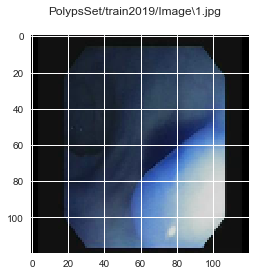

In [49]:
plt.suptitle(train_X_filepaths[0])
plt.imshow(train_X_images[0])

In [50]:
train_X_images[0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [51]:
train_X_images[0].shape

(120, 120, 3)

In [52]:
train_X_images

[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8), array([[[17, 17, 17],
         [17, 17, 17],
         [17, 17, 17],
         ...,
         [17, 17, 17],
         [17, 17, 17],
         [17, 17, 17]]

In [ ]:
# train_X_images_scaled = normalize_images(train_X_images)

In [ ]:
# X_train_images = np.array(train_X_images)

In [ ]:
# X_train_images

In [19]:
# label_enc = LabelEncoder()

In [20]:
# train_y_polyp_names_enc = label_enc.fit_transform(train_y_polyp_names)

NameError: name 'train_y_polyp_names' is not defined

In [ ]:
# train_y_polyp_names_enc

In [ ]:
# sns.countplot(train_y_polyp_names)

In [ ]:
# polyp_counter = collections.Counter(train_y_polyp_names)

In [ ]:
# polyp_counter.keys

In [ ]:
# polyp_counter

## Build Fully Convolutional Network

In [53]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Input, Flatten, Dense, Activation, Lambda, Cropping2D, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import GlobalMaxPooling2D

In [72]:
len_classes=3
dropout_rate=0.2

model = Sequential()
model.add(Lambda(lambda x: (x/255.0) - 0.5, input_shape = (120, 120, 3)))
model.add(Conv2D(filters=64, kernel_size=3, strides=1))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(filters=64, kernel_size=3, strides=1))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(filters=64, kernel_size=1, strides=1))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())
model.add(GlobalMaxPooling2D())
model.add(Activation("relu"))

model.add(Flatten())
# Layer 7: Fully Connected
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))
# Layer 8: Fully Connected
model.add(Dense(50))
model.add(BatchNormalization())
model.add(Activation('relu'))
# Layer 9: Fully Connected
model.add(Dense(10))
model.add(BatchNormalization())
model.add(Activation('softmax'))
# Layer 10: Fully Connected
model.add(Dense(3))


# def FCN_model(len_classes=3, dropout_rate = 0.2):
# input = keras.layers.Input(shape=(120, 120, 3))
    
#     # Fully convolution layer 1
# x = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1)(input)
# x = keras.layers.Dropout(dropout_rate)(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Activation("relu")(x)

# #     # Fully convolution layer 2
# x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=1)(input)
# x = keras.layers.Dropout(dropout_rate)(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Activation("relu")(x)
    
# #     # Fully Connected Convolution layer 1
# x = keras.layers.Conv2D(filters=len_classes, kernel_size=1, strides=1)(x)
# x = keras.layers.Dropout(dropout_rate)(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.GlobalMaxPooling2D()(x)
# predictions = keras.layers.Activation("softmax")(x)
    
# model = keras.Model(inputs=input, outputs=predictions)
print(model.summary())
# print(f"Total number of layers: {len(model.layers)}")
    
#     return model

ValueError: Input 0 is incompatible with layer flatten_2: expected min_ndim=3, found ndim=2

In [30]:
# model = FCN_model(len_classes=3, dropout_rate=0.2)

## Train FCN Model

In [55]:
X_train = np.array(train_X_images)
y_train = np.array(train_y_polyp_names_onehot)

In [56]:
X_train.shape

(28773, 120, 120, 3)

In [ ]:
# X_train_copy = X_train.copy()

In [ ]:
# X_train_copy.reshape(-1, 288,384,3)

In [57]:
X_train[0].shape

(120, 120, 3)

In [69]:
model.compile(loss="categorical_crossentropy", 
              optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=2)

ValueError: Error when checking target: expected conv2d_21 to have 4 dimensions, but got array with shape (28773, 1)

We have more cancerous polyps (adenomatous) in our training data set compared to non cancerous polyps (hyperplastic).

In [ ]:
model.save("fcn_model.h5")

## Resources

- [Three Ways of Storing and Accessing Lots of Images in Python](https://realpython.com/storing-images-in-python/#reading-a-single-image)

- [Understanding and implementing a fully convolutional network (FCN)](https://towardsdatascience.com/implementing-a-fully-convolutional-network-fcn-in-tensorflow-2-3c46fb61de3b)